# Loveida Lucero

# ARIMA Models (Core)
- Load this [Walmart stock data](https://drive.google.com/file/d/1KKR8TZbkixVN2NundM2mEVv5AhjHhs9a/view?usp=sharing)​.    ([source](https://www.kaggle.com/datasets/meetnagadia/walmart-stock-price-from-19722022)​​)
- We will use data from 2010 to 2020 to predict the  Adjusted Close values for the next quarter.
- Make a datetime index using the Date column with a business day frequency ('B')
- Check for and address null values.
- Check the time series for stationarity.
  - Determine the number of differencing (d) needed to make the data stationary. (We recommend using pmdarima's ndiffs)
- Use ACF/PACF plots of the stationary data to estimate initial time series model orders​ (p,d,q)
- Split the time series into training and test data. Use a test_size of one quarter (13 weeks X 5 business days)
- Fit an ARIMA model based on the orders determined during your exploration.
  - Make forecasts with your model.
  - Plot the forecasts versus the test data.
  - Obtain metrics for evaluation.
- Try at least one variation of the model for comparison (we recommend using a loop to try combinations of model orders)
- A MAPE of less than 2% on the test data is achievable.
- Choose a final model and explain:
  - How good was your model, according to your Mean Absolute Percentage Error?
  - How good was your model in terms of how well the forecast seems to follow the test data, visually?  (Hint: You may want to plot fewer training data lags to see this)

**Imports**

In [1]:
# Commented out to avoid reinstalling 
#!pip install pmdarima

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.tsa.api as tsa
from pmdarima.model_selection import train_test_split
from pmdarima.arima.utils import ndiffs
import itertools

**Custom Functions**

In [3]:
# Custom function for Ad Fuller Test
def get_adfuller_results(ts, alpha=.05, label='adfuller', **kwargs): #kwargs for adfuller()
    # Saving each output
    (test_stat, pval, nlags, nobs, crit_vals_d, 
    icbest ) = tsa.adfuller(ts, **kwargs)
    # Converting output to a dictionary with the interpretation of p
    adfuller_results = {'Test Statistic': test_stat,
                        "# of Lags Used":nlags, 
                       '# of Observations':nobs,
                        'p-value': round(pval,6),
                        'alpha': alpha,
                       'sig/stationary?': pval < alpha}
    return pd.DataFrame(adfuller_results, index =[label])

In [4]:
def plot_acf_pacf(ts, nlags=40, figsize=(10, 5), 
                  annotate_sig=False, alpha=.05,
                 acf_kws={}, pacf_kws={},  
                  annotate_seas=False, m = None,
                 seas_color='black'):
    
    fig, axes = plt.subplots(nrows=2, figsize=figsize)
    
    # Sig lags line style
    sig_vline_kwargs = dict( ls=':', lw=1, zorder=0, color='red')
    # ACF
    tsa.graphics.plot_acf(ts, ax=axes[0], lags=nlags, **acf_kws)
    
    ## Annotating sig acf lags
    if annotate_sig == True:
        sig_acf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='ACF')
        for lag in sig_acf_lags:
            axes[0].axvline(lag,label='sig', **sig_vline_kwargs )
    # PACF
    tsa.graphics.plot_pacf(ts,ax=axes[1], lags=nlags, **pacf_kws)
    
    ## Annotating sig pacf lags
    if annotate_sig == True:
        ## ANNOTATING SIG LAGS
        sig_pacf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='PACF')
        for lag in sig_pacf_lags:
            axes[1].axvline(lag, label='sig', **sig_vline_kwargs)
    
    ### ANNOTATE SEASONS
    if annotate_seas == True:
        # Ensure m was defined
        if m is None:
            raise Exception("Must define value of m if annotate_seas=True.")
        ## Calculate number of complete seasons to annotate
        n_seasons = nlags//m 
        # Seasonal Lines style
        seas_vline_kwargs = dict( ls='--',lw=1, alpha=.7, color=seas_color, zorder=-1)
        
        ## for each season, add a line
        for i in range(1, n_seasons+1):
            axes[0].axvline(m*i, **seas_vline_kwargs, label="season")
            axes[1].axvline(m*i, **seas_vline_kwargs, label="season")
    fig.tight_layout()
    
    return fig

In [5]:
def plot_forecast(ts_train, ts_test, forecast_df, n_train_lags=None, 
                  figsize=(10,4), title='Comparing Forecast vs. True Data'):
    ### PLot training data, and forecast (with upper/,lower ci)
    fig, ax = plt.subplots(figsize=figsize)

    # setting the number of train lags to plot if not specified
    if n_train_lags==None:
        n_train_lags = len(ts_train)
            
    # Plotting Training  and test data
    ts_train.iloc[-n_train_lags:].plot(ax=ax, label="train")
    ts_test.plot(ax=ax, label="test")

    # Plot forecast
    forecast_df['mean'].plot(ax=ax, color='green', label="forecast")

    # Add the shaded confidence interval
    ax.fill_between(forecast_df.index, 
                    forecast_df['mean_ci_lower'],
                   forecast_df['mean_ci_upper'],
                   color='green', alpha=0.3,  lw=2)

    # set the title and add legend
    ax.set_title(title)
    ax.set_ylabel('Adjusted Closing Price')
    ax.legend();
    
    return fig, ax

In [6]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

def regression_metrics_ts(ts_true, ts_pred, label="", verbose=True, output_dict=False,):
    # Get metrics
    mae = mean_absolute_error(ts_true, ts_pred)
    mse = mean_squared_error(ts_true, ts_pred)
    rmse = mean_squared_error(ts_true, ts_pred, squared=False)
    r_squared = r2_score(ts_true, ts_pred)
    mae_perc = mean_absolute_percentage_error(ts_true, ts_pred) * 100

    if verbose == True:
        # Print Result with label
        header = "---" * 20
        print(header, f"Regression Metrics: {label}", header, sep="\n")
        print(f"- MAE = {mae:,.3f}")
        print(f"- MSE = {mse:,.3f}")
        print(f"- RMSE = {rmse:,.3f}")
        print(f"- R^2 = {r_squared:,.3f}")
        print(f"- MAPE = {mae_perc:,.2f}%")

    if output_dict == True:
        metrics = {
            "Label": label,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse,
            "R^2": r_squared,
            "MAPE(%)": mae_perc,
        }
        return metrics

**Load Data**

In [7]:
df = pd.read_csv('Data/WMT.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5479 entries, 0 to 5478
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       5479 non-null   object 
 1   Adj Close  5284 non-null   float64
dtypes: float64(1), object(1)
memory usage: 85.7+ KB


,Date,Adj Close
0,2000-01-03,44.915394
1,2000-01-04,43.234756
2,2000-01-05,42.352402
3,2000-01-06,42.814564
4,2000-01-07,46.049828


## Make a datetime index using the Date column with a business day frequency ('B')

In [8]:
# Make Date a datetime object 
df['Date'] = pd.to_datetime(df['Date'])
# Make Date the index
df = df.set_index('Date')
# We have weekly data so we will set our frequency to W
df.index.freq= "B"

## We will use data from 2010 to 2020 to predict the Adjusted Close values for the next quarter.

In [9]:
df = df.loc['2010':'2020']
df

,Adj Close
Date,
2010-01-01,NaN
2010-01-04,40.963638
2010-01-05,40.555729
2010-01-06,40.465084
2010-01-07,40.487759
...,...
2020-12-25,NaN
2020-12-28,142.946777
2020-12-29,142.041183


## Check for and address null values.

In [10]:
# display null counts
df.isna().sum()

Adj Close    101
dtype: int64

In [11]:
# forward fill nulls
df = df.ffill()

# confirm dropped nulls
df.isna().sum()

Adj Close    1
dtype: int64

In [12]:
df = df.dropna()
df.isna().sum()

Adj Close    0
dtype: int64

## Check the time series for stationarity.
- Determine the number of differencing (d) needed to make the data stationary. (We recommend using pmdarima's ndiffs)

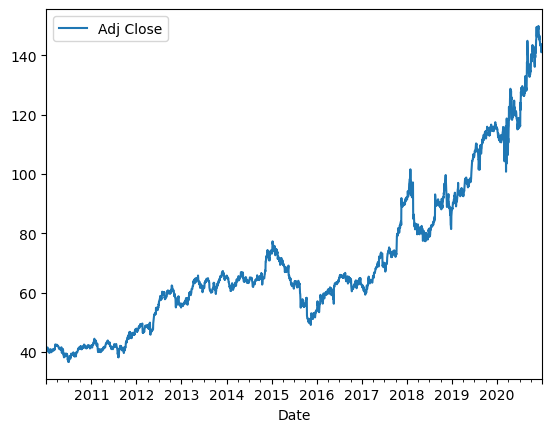

In [13]:
df.plot();

In [14]:
# tsa.adfuller(df)
get_adfuller_results(df)

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,1.436262,23,2845,0.997273,0.05,False


In [15]:
# obtaing diff number
ndiffs(df)

1

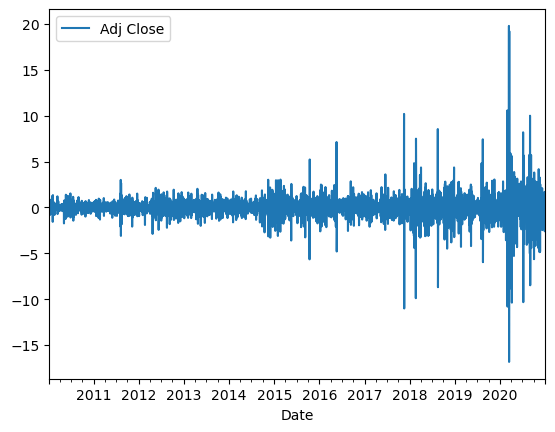

In [16]:
# define new df with 2 diffs
df_diff2 = df.diff().diff()
df_diff2 = df_diff2.dropna()

#plot new df
df_diff2.plot();

In [17]:
# is it stationary?
get_adfuller_results(df_diff2)

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,-18.757916,28,2838,0.0,0.05,True


## Use ACF/PACF plots of the stationary data to estimate initial time series model orders​ (p,d,q)

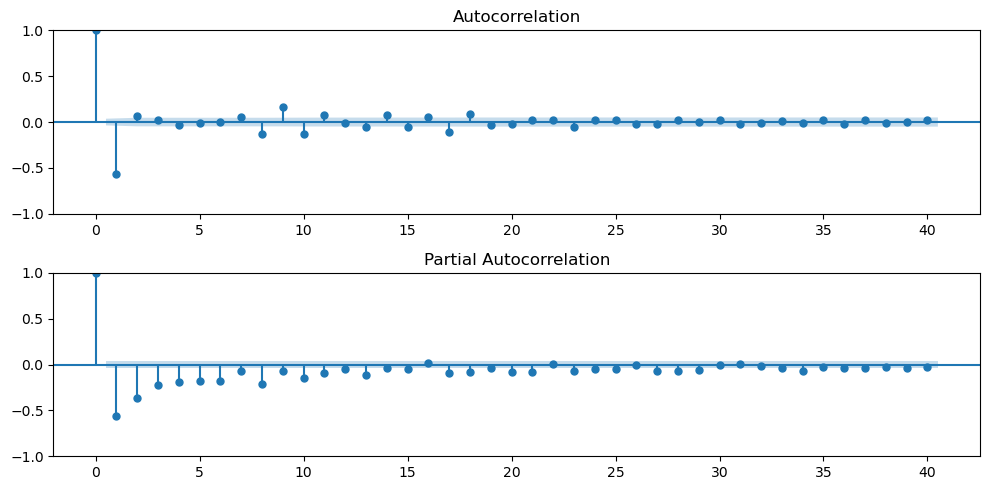

In [18]:
plot_acf_pacf(df_diff2);

## Split the time series into training and test data. Use a test_size of one quarter (13 weeks X 5 business days)

In [19]:
13*5

65

In [20]:
# train test split
train, test = train_test_split(df, test_size = 65)

train.shape, test.shape

((2804, 1), (65, 1))

## Fit an ARIMA model based on the orders determined during your exploration.
- Make forecasts with your model.
- Plot the forecasts versus the test data.
- Obtain metrics for evaluation.

*Try at least one variation of the model for comparison (we recommend using a loop to try combinations of model orders)*

In [21]:
# Define the value or range of values for p, d, q
p_values = range(0, 3)  
d_values = [2]          
q_values = range(0, 3)  

# Create combinations of pdq to test
pdq_to_try = list(itertools.product(p_values, d_values, q_values))
                                            
pdq_to_try

[(0, 2, 0),
 (0, 2, 1),
 (0, 2, 2),
 (1, 2, 0),
 (1, 2, 1),
 (1, 2, 2),
 (2, 2, 0),
 (2, 2, 1),
 (2, 2, 2)]

In [22]:
# define starting aic as infinity
best_aic = float("inf")  

# define baseline for pdq
best_pdq = (0,0,0)

# Loop through each combination
for pdq in pdq_to_try:
    
    model = tsa.ARIMA(train, order=pdq)
                              
    result = model.fit()
    
    print(pdq, result.aic)      
    
    # If lower, replace best AIC with new value
    if result.aic < best_aic:
        
        best_aic = result.aic
        best_pdq = pdq

# Print the best orders and AIC score
print("Best AIC:", best_aic)
print("Best pdq:", best_pdq)

(0, 2, 0) 10068.207225613129
(0, 2, 1) 7821.748746783868
(0, 2, 2) 7783.696719426664
(1, 2, 0) 8997.554695452196
(1, 2, 1) 7782.642648986841
(1, 2, 2) 7784.5274244491975
(2, 2, 0) 8619.313632625703
(2, 2, 1) 7784.521028372337


C:\Users\Lovei\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Lovei\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(2, 2, 2) 7781.20249256885
Best AIC: 7781.20249256885
Best pdq: (2, 2, 2)


### Best Model

In [23]:
# Define pdq
p = 0
d = 2
q = 2

# fit best pdq to model
model = tsa.ARIMA(df, order=(p, d, q)).fit()

# display model summary
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Adj Close   No. Observations:                 2869
Model:                 ARIMA(0, 2, 2)   Log Likelihood               -4009.301
Date:                Fri, 01 Dec 2023   AIC                           8024.603
Time:                        10:30:10   BIC                           8042.486
Sample:                    01-04-2010   HQIC                          8031.050
                         - 12-31-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.1209      0.006   -180.923      0.000      -1.133      -1.109
ma.L2          0.1217      0.006     19.869      0.000       0.110       0.134
sigma2         0.9576      0.007    145.423      0.000       0.945       0.971
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):            103346.95
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):              10.78   Skew:                             0.89
Prob(H) (two-sided):                  0.00   Kurtosis:                        32.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

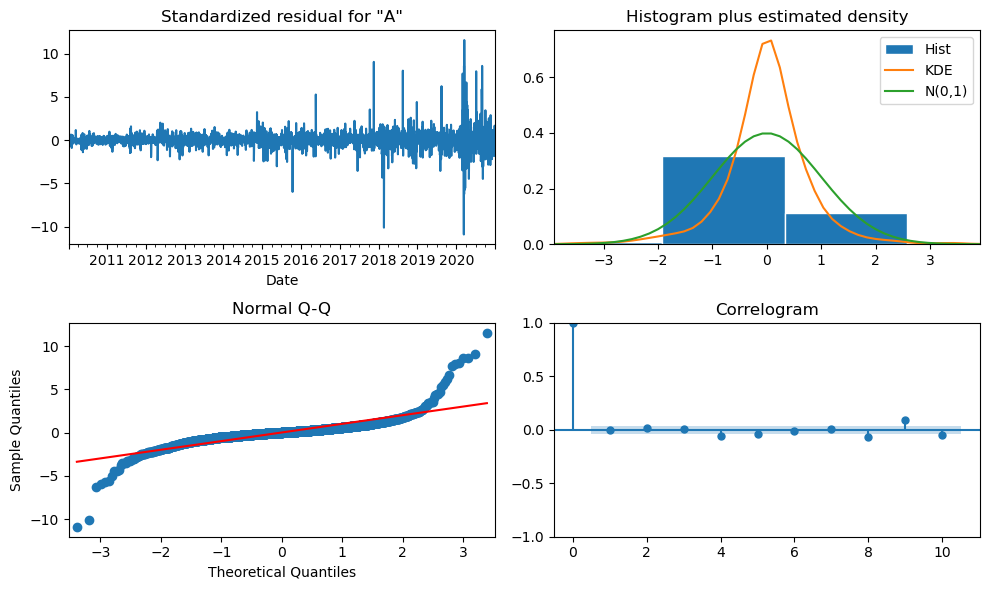

In [24]:
# Obtain diagnostic plots
fig = model.plot_diagnostics()
fig.set_size_inches(10,6)
fig.tight_layout()

### Alternate model

In [25]:
# Define pdq
p = 0
d = 2
q = 0

# fit best pdq to model
model2 = tsa.ARIMA(df, order=(p, d, q)).fit()

# display model summary
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Adj Close   No. Observations:                 2869
Model:                 ARIMA(0, 2, 0)   Log Likelihood               -5188.820
Date:                Fri, 01 Dec 2023   AIC                          10379.641
Time:                        10:30:11   BIC                          10385.602
Sample:                    01-04-2010   HQIC                         10381.790
                         - 12-31-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         2.1854      0.013    166.828      0.000       2.160       2.211
===================================================================================
Ljung-Box (L1) (Q):                 911.06   Jarque-Bera (JB):            162291.28
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              12.53   Skew:                             0.72
Prob(H) (two-sided):                  0.00   Kurtosis:                        39.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

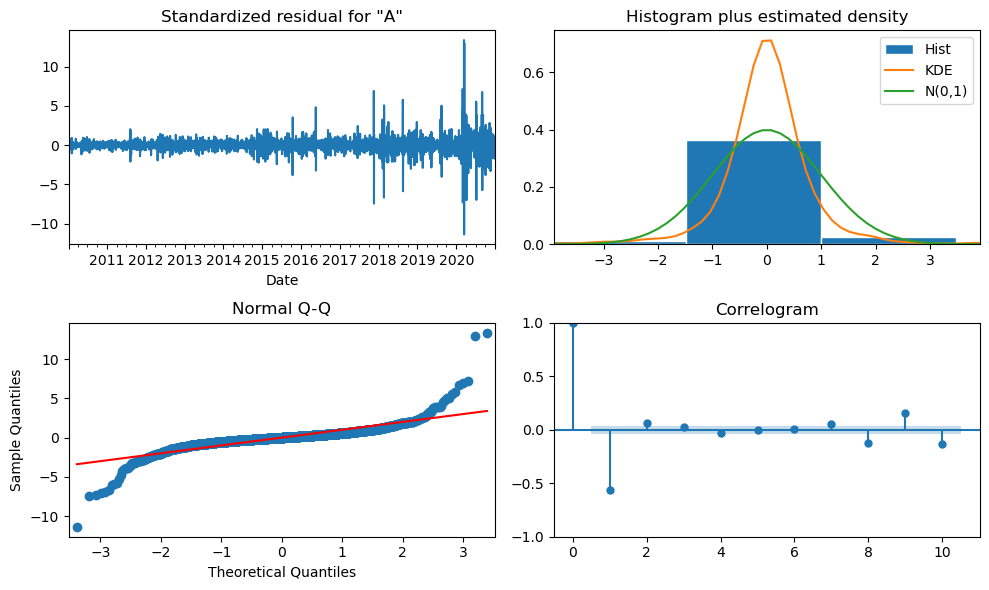

In [26]:
# Obtain diagnostic plots
fig = model2.plot_diagnostics()
fig.set_size_inches(10,6)
fig.tight_layout()

## Choose a final model and explain:
- How good was your model, according to your Mean Absolute Percentage Error?
- How good was your model in terms of how well the forecast seems to follow the test data, visually? (Hint: You may want to plot fewer training data lags to see this)

In [27]:
# Obtain summary of forecast as dataframe
forecast_df = model.get_forecast(len(test)).summary_frame()
forecast_df2 = model2.get_forecast(len(test)).summary_frame()

best = regression_metrics_ts(test, forecast_df['mean'])
print(f'Model (0,2,2) \n{best}')

alternate = regression_metrics_ts(test, forecast_df2['mean'])
print(f'Model (0,2,0) \n{alternate}')

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 2.854
- MSE = 10.916
- RMSE = 3.304
- R^2 = 0.151
- MAPE = 2.00%
Model (0,2,2) 
None
------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 3.617
- MSE = 19.779
- RMSE = 4.447
- R^2 = -0.538
- MAPE = 2.50%
Model (0,2,0) 
None


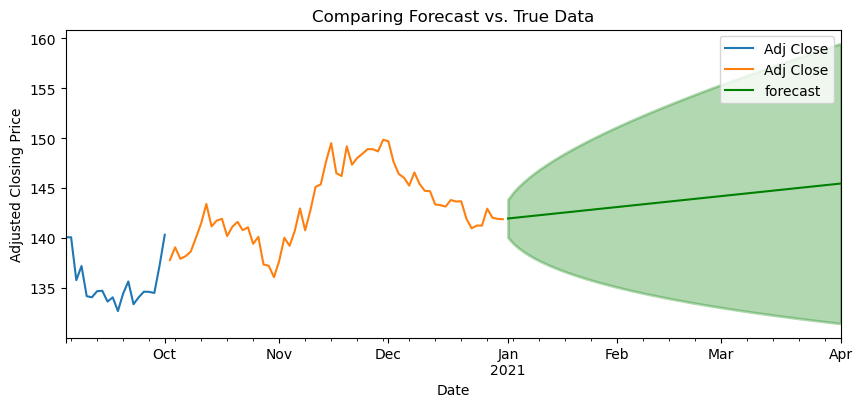

In [28]:
# Plot the forecast with true values zoomed in to better view the forecast
plot_forecast(train.tail(20), test, forecast_df);

- The ARIMA (0,2,2) performs better in each metric including Mean Absolute Percentage Error(MAPE).
- The model was very good in terms of forecast given that the window/margin of error is failry small as well as aligns and follows the same trend (despite the ever slightly lower placement)as the plotted data. 